In [101]:
#import all libraries we need
import torch as tc
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torch import nn
from torchvision import models
import torch.nn.functional as F
from torch import optim
from sklearn.utils import shuffle as shuff

In [102]:
import sys
!{sys.executable} -m pip install nbimporter


In [103]:
import nbimporter
import densenet
#import densenet1
import cNet

In [104]:
def is_GPU():
    train_mode = tc.cuda.is_available()
    return "Training on GPU" if train_mode else "Training on CPU"

def device():
    return 'cuda' if tc.cuda.is_available() else 'cpu'

print(is_GPU())

Training on CPU


In [105]:
#loading/preprocessing data
def preprocessing(num_workers=2, validation_size=0.2):
    #create the train_transform
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomCrop(32, pad_if_needed=True),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                                             std =  (0.2023, 0.1994, 0.2010))
                                         ])
    
    #set up the test transform
    test_transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                                             std =  (0.2023, 0.1994, 0.2010))])
    
    #Get the data
    train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    #define index for train and validation set
    ind = shuff([x for x in range(len(train_set))])
    split_size = np.int0(validation_size * len(train_set))
    train_index, valid_index = ind[split_size:], ind[:split_size]

    #train and validation samplers
    train_sampler, valid_sampler = SubsetRandomSampler(train_index), SubsetRandomSampler(valid_index)

    train_loader = tc.utils.data.DataLoader(train_set, batch_size=128, sampler=train_sampler, num_workers=num_workers)
    valid_loader = tc.utils.data.DataLoader(train_set, batch_size=128, sampler=valid_sampler, 
                                               shuffle=False, num_workers=num_workers)
    test_loader = tc.utils.data.DataLoader(test_set, batch_size=100, shuffle=False, num_workers = num_workers)

    classes = ['plane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    return train_loader, valid_loader, test_loader, classes

train_loader, valid_loader, test_loader, classes = preprocessing()

Files already downloaded and verified
Files already downloaded and verified


In [124]:
#Enter either denseNet, or cNet
#cNet could give an accuracy of about 85% while denseNet could give over 95%. 
#Increase the range of the epoch to say 201 when running on a GPU, this wouldnt make much difference for cNet though.
mod_name = input('Enter the model to classify with (enter either denseNet or cNet)\n ')
while(mod_name != 'denseNet' and mod_name != 'cNet'):
    mod_name = input('Enter the model to classify with (enter either denseNet or cNet)\n')

model = densenet.denseNet() if mod_name == 'denseNet' else cNet.convNet()

#model = densenet.denseNet()
#model = densenet2.densenet_cifar()

model = model.to(device())

Enter the model to classify with (enter either denseNet or cNet)
 ada
Enter the model to classify with (enter either denseNet or cNet)
aka
Enter the model to classify with (enter either denseNet or cNet)
cNet


In [131]:
#sgd optimizer is better for this very dataset
optimize = input('Enter the optimizer to use (enter sgd or adam) ')
while(optimize != 'sgd' and optimize != 'adam'):
    optimize = input('Enter the optimizer to use (enter sgd or adam) ')

if optimize == 'sgd':
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
elif optimize == 'adam':
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)


Enter the optimizer to use (enter sgd, adam) adam


In [132]:
valid_loss_min = np.Inf # set the lowest validation loss to infinity for the first step

def train(epoch):
    global valid_loss_min
    # keep track of training and validation loss
    train_loss, valid_loss = 0.0, 0.0
    
    #the training process
    model.train()
    for data, target in train_loader:
        
        data, target = data.to(device()), target.to(device()) # move tensors to GPU if CUDA is available
        optimizer.zero_grad() # clear gradients of all optimized variables        
        output = model.forward(data) #run a forward pass to compute the predicted output by forward passing inputs        
        loss = criterion(output, target) #compute the batch loss        
        loss.backward() #run backward pass to compute gradient of the loss        
        optimizer.step() #take an optimization step        
        train_loss += loss.item() #update the training loss
        
    #the valuation process
    model.eval()
    for data, target in valid_loader:
        
        data, target = data.to(device()), target.to(device()) #if CUDA exists, move tensor to GPU        
        output = model.forward(data) #run a forward pass to compute the predicted output by forward passing inputs        
        loss = criterion(output, target)#compute the batch loss                
        valid_loss += loss.item() #update the validation loss
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation results 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saved ...'.format(valid_loss_min,valid_loss))
        tc.save(model.state_dict(), 'model_saved.pt')
        valid_loss_min = valid_loss
    else:
        print('Validation loss did not decrease.   Not saved...')
    return


In [ ]:
#run the train block
for epoch in range(1, 31):
    train(epoch)

Epoch: 1 	Training Loss: -3025490613459.318848 	Validation Loss: -5540897870032.404297
Validation loss decreased (inf --> -5540897870032.404297).  Saved ...
Epoch: 2 	Training Loss: -339000800974198.562500 	Validation Loss: -282422635131117.250000
Validation loss decreased (-5540897870032.404297 --> -282422635131117.250000).  Saved ...
Epoch: 3 	Training Loss: -4112415744309980.000000 	Validation Loss: -2327866238113163.500000
Validation loss decreased (-282422635131117.250000 --> -2327866238113163.500000).  Saved ...
Epoch: 4 	Training Loss: -21078190180910216.000000 	Validation Loss: -9664359707501082.000000
Validation loss decreased (-2327866238113163.500000 --> -9664359707501082.000000).  Saved ...
Epoch: 5 	Training Loss: -69869401499675112.000000 	Validation Loss: -28208170525885348.000000
Validation loss decreased (-9664359707501082.000000 --> -28208170525885348.000000).  Saved ...


In [25]:
#load the best model (ie the model with the least validation loss)
model.load_state_dict(tc.load('model_saved.pt'))
#classes = ('plane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

#test the model
def test():
    global classes
    test_loss = 0.0
    correct = np.zeros(10)
    total = np.zeros(10)
    
    model.eval() #enter evaluation mode
    
    #run an iteration over the test set
    with tc.no_grad():
        for data, target in test_loader:
            data, target = data.to(device()), target.to(device()) #move tensor to GPU, if exists
            output = model.forward(data) #run a forward pass
            loss = criterion(output, target)
            test_loss += loss.item()
        
            _, pred = output.max(1) #predicted class output probabilities
            total += target.size(0)
            correct += pred.eq(target).sum().item()
            
            return ('Overall Accuracy: %3d%%' % (100. * np.sum(correct)/np.sum(total)) )                                                   
            

In [26]:
#run the test block
test()

'Overall Accuracy:  79%'

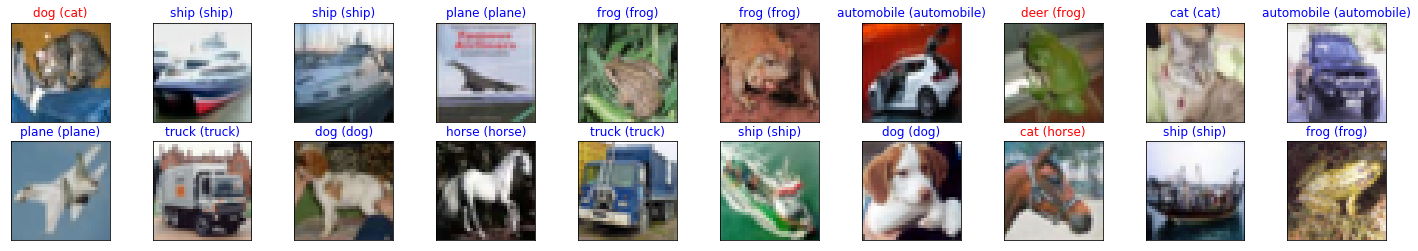

In [29]:
%matplotlib inline
#uncomment this if it says string out of range
#classes = ['plane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def show_image(images):
    inverse_normalize = transforms.Normalize(mean=(-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010),
                                             std =  (1/0.2023, 1/0.1994, 1/0.2010))
    
    images = inverse_normalize(images)
    plt.imshow(np.transpose(images, (1, 2, 0)))


def visualize(test_loader):
    global classes
    images, labels = next(iter(test_loader)) #get a batch of test image
    images.numpy()
    images.to(device())

    output = model.forward(images) #get output sample

    _, pred = output.max(1) #convert output probabilities to predicted class. We can use _, pred = tc.max(output, 1)
    out_preds = np.squeeze(pred.cpu().numpy()) if device() == 'cuda' else np.squeeze(pred.numpy())

    #plot the batch images
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        #unnormalize image
        show_image(images[idx])
        ax.set_title("{} ({})".format(classes[out_preds[idx]], classes[labels[idx]]),
                     color=("blue" if out_preds[idx]==labels[idx].item() else "red"))

visualize(test_loader)

In [85]:
from PIL import Image
def your_custom_image(image):
    #classifies ['plane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']    
    transform = transforms.Compose([
                                    transforms.RandomResizedCrop(32),
                                    
                                    transforms.RandomCrop(32, pad_if_needed=True),
                                    transforms.ToTensor(),                                    
                                    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                                             std =  (0.2023, 0.1994, 0.2010))])
    my_input = transform(my_image).unsqueeze_(0)
    my_input.numpy()
    output = model.forward(my_input)
    _, pred = output.max(1)
        
    outpred = np.squeeze(pred.numpy())
    return classes[outpred]

In [123]:
my_image = Image.open('./img_test.jpg')
your_custom_image(my_image)

'horse'